# Initialisations

In [56]:
from rwa_functions import *  # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [57]:
class VelocityCNN(nn.Module):
    def __init__(self):
        super(VelocityCNN, self).__init__()    
        # Define convolutional layers
        self.conv1 = nn.Conv2d(15, 16, kernel_size=7, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
        # Define regressor
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 128),  # Adjust the size based on the output from the last pooling layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 6)  # Output Layer for x, y coordinates and velocity
        )

    def forward(self, x):
        # Apply convolutional layers with activations, pooling and normalization
        x1 = self.conv1(x)
        x = self.relu(x1)
        x = self.norm1(self.pool(x))
        x2 = self.conv2(x)
        x = self.relu(x2)
        x = self.norm2(self.pool(x))
        x3 = self.conv3(x)
        x = self.relu(x3)
        x = self.norm3(self.pool(x))
        
        # Apply regressor
        x = self.regressor(x)
        
        return x1, x2

In [58]:
# Define the network and the trained model
# visual only - no proprioception; agent learns a policy based on visual input only
net = VelocityCNN()

# load trained model
model_filename = './cnn_training/velocity_cnn32.pt'
net.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

<All keys matched successfully>

# Lab Recording Room

In [73]:
# Experiment settings
batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv2'
dims = [32, 15] # dim noise input, 3 channels

# Get centre locations of receptive field to record activation (arbitrary choice)
net.eval()
X = (torch.rand(batch_size, dims[1], dims[0], dims[0]) - 0.5) * 255 # colored noise pattern ensemble, zero mean
x1, x2 = net(X)
if layer == 'conv1':
    nR,nC = x1[0,0,:,:].shape
elif layer == 'conv2':
    nR,nC = x2[0,0,:,:].shape
print(f'Size of {layer} activation map: ({nR}, {nC})')
locs = [int(round(float(nR)/2.0)), int(round(float(nC)/2.0))] # location of the centre pixel
print(f'r, c centre locations of the receptive fields are ({locs[0]}, {locs[1]})')

# Recording
if layer == 'conv1':
    act_conv1, noise1 = ActRecorder(layer, net, 'fetch', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise1.min(), noise1.max(), noise1.mean()}')
    # Remove biases
    for unit in range(act_conv1.shape[0]):
        act_conv1[unit] -= net.state_dict()['conv1.bias'][unit]
        
elif layer == 'conv2':
    act_conv2, noise2 = ActRecorder(layer, net, 'fetch', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise2.min(), noise2.max(), noise2.mean()}')
    # Remove biases
    for unit in range(act_conv2.shape[0]):
        act_conv2[unit] -= net.state_dict()['conv2.bias'][unit]

Size of conv2 activation map: (12, 12)
r, c centre locations of the receptive fields are (6, 6)


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Activation recording complete.


100%|██████████| 32/32 [00:00<00:00, 121.72it/s]


Shape of activation response list: torch.Size([32, 50000])
Shape of noise list: torch.Size([50000, 32, 32, 15])
min, max and mean of noise: (tensor(-127.5000), tensor(127.5000), tensor(-0.0007))


# Conv1 - Zero Mean [-127.5, 127,5]

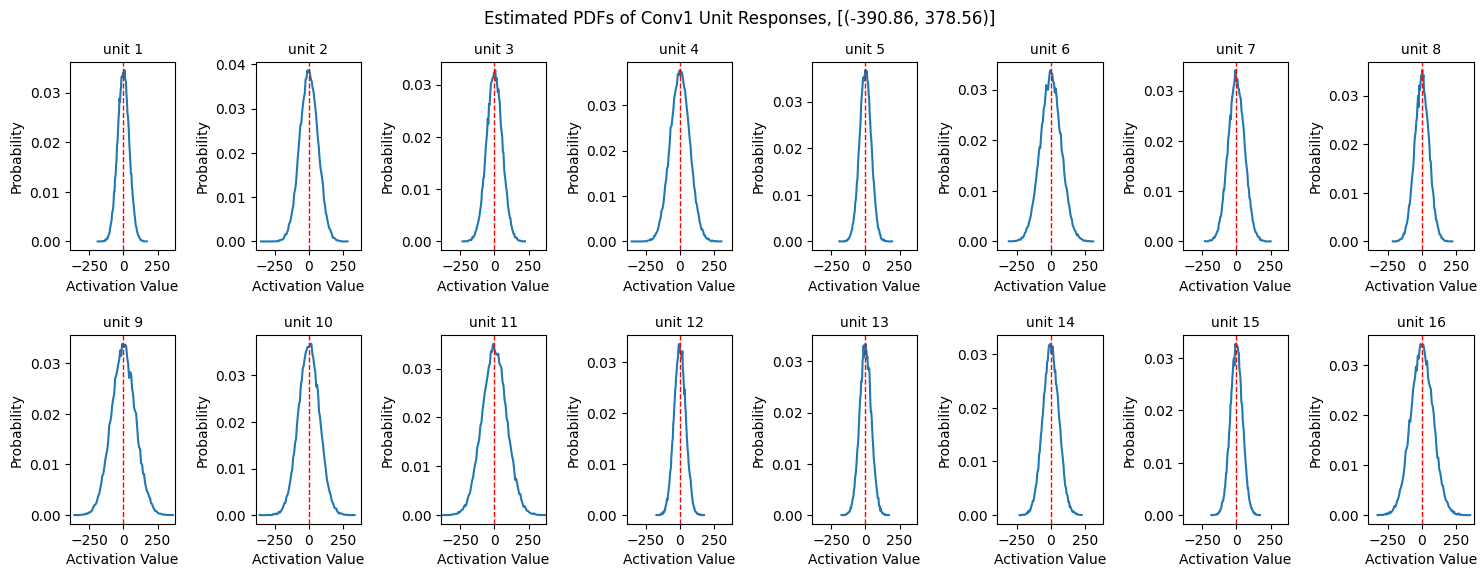

In [61]:
# PDFs of conv1 responses
# Gaussian because of CLT
for i in range(act_conv1.shape[0]):
    # plot initialisation
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    # plot the PDF of the activation values
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else: # display "unit dead"
        plt.text(0.5, 0.5, 'unit dead', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle(f'Estimated PDFs of Conv1 Unit Responses, [{np.round(float(act_conv1.min()),2), np.round(float(act_conv1.max()),2)}]')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 11)
plt.show()

In [62]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)

100%|██████████| 800000/800000 [00:17<00:00, 44954.25it/s]


Shape of receptive field list: torch.Size([16, 32, 32, 15])


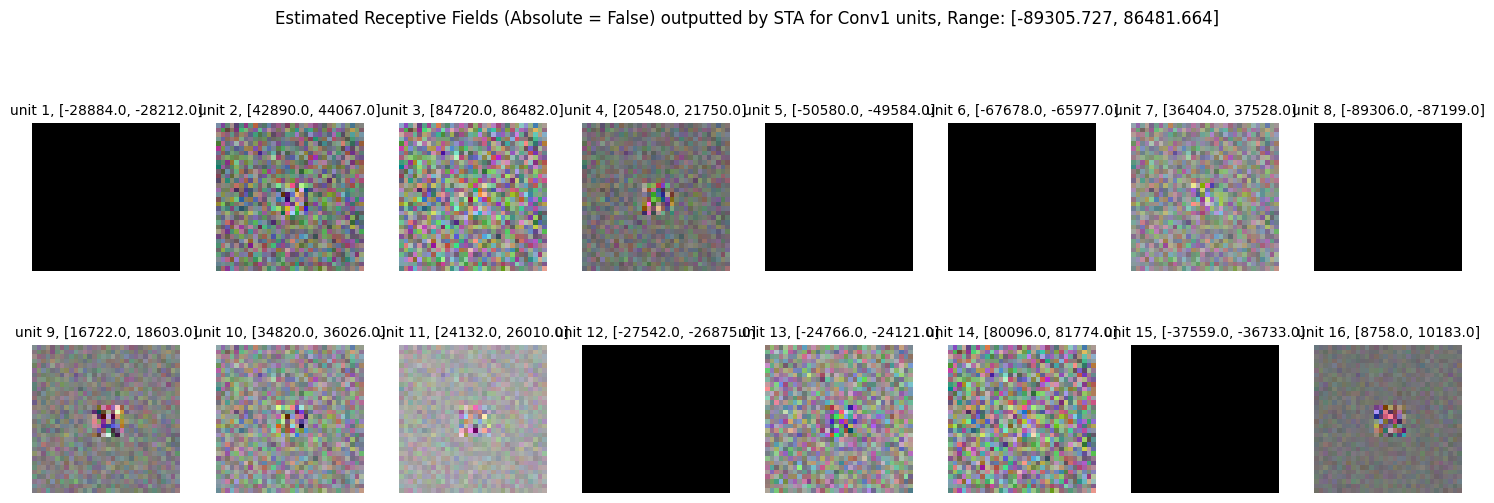

In [69]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i, :, :, 9:12]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}, [{np.round(rf1[i].min())}, {np.round(rf1[i].max())}]', fontsize=10)
    
# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields (Absolute = False) outputted by STA for Conv1 units, Range: {[np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

# Conv1 - [0, 255]

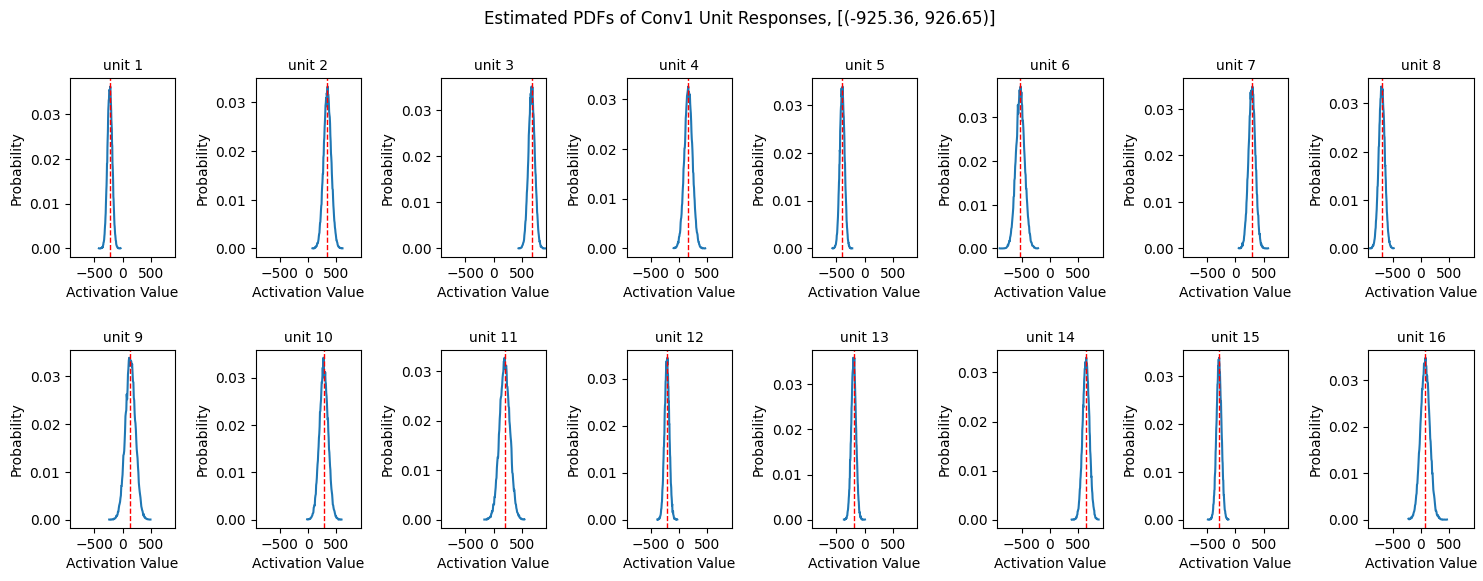

In [65]:
# PDFs of conv1 responses
# Gaussian because of CLT
for i in range(act_conv1.shape[0]):
    # plot initialisation
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    # plot the PDF of the activation values
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else: # display "unit dead"
        plt.text(0.5, 0.5, 'unit dead', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle(f'Estimated PDFs of Conv1 Unit Responses, [{np.round(float(act_conv1.min()),2), np.round(float(act_conv1.max()),2)}]')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

In [66]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)

  0%|          | 0/800000 [00:00<?, ?it/s]

100%|██████████| 800000/800000 [00:19<00:00, 41829.91it/s]

Shape of receptive field list: torch.Size([16, 32, 32, 15])


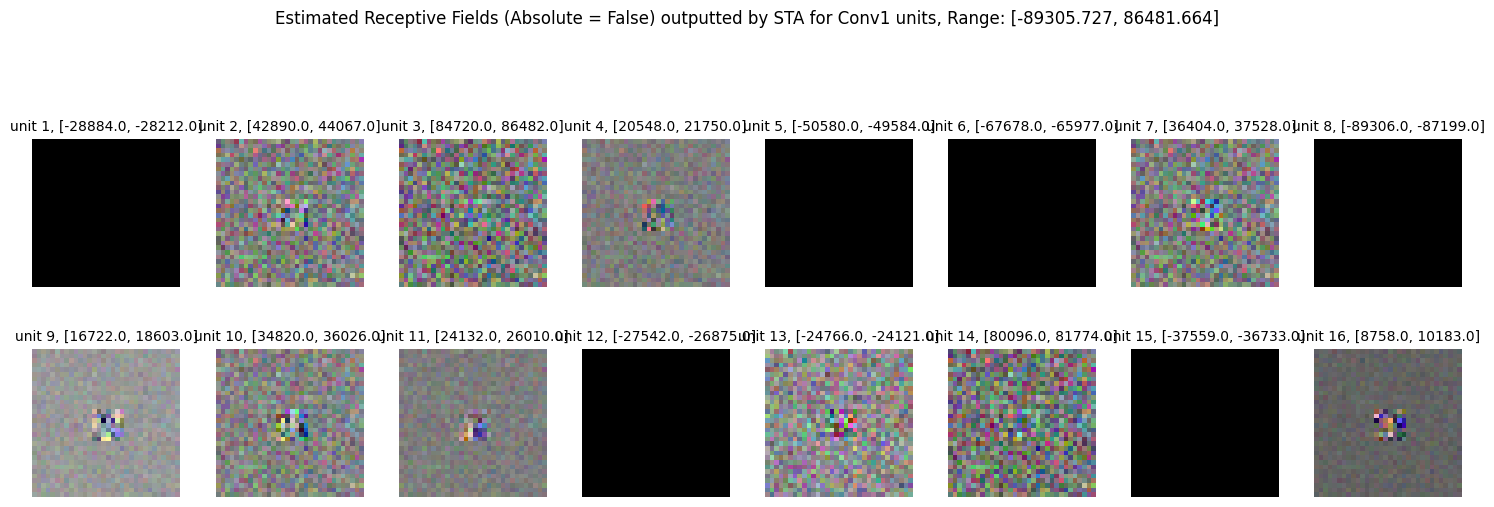

In [67]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i, :, :, 12:15]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}, [{np.round(rf1[i].min())}, {np.round(rf1[i].max())}]', fontsize=10)
    
# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields (Absolute = False) outputted by STA for Conv1 units, Range: {[np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

Receptive Field Estimation via Pearson Correlation


In [29]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 16384/16384 [00:51<00:00, 320.74it/s]


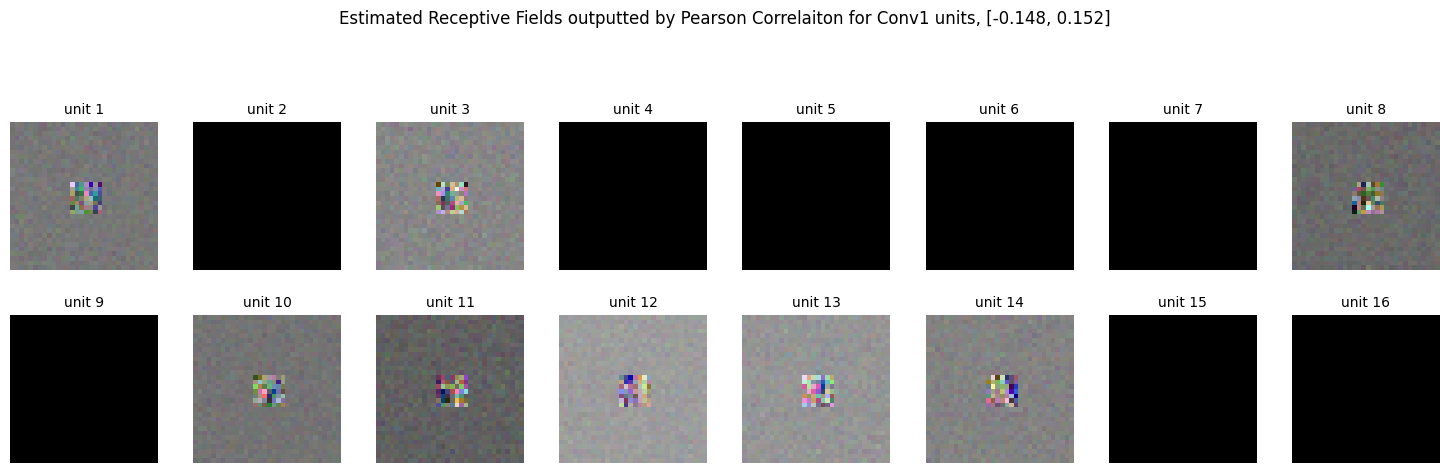

In [55]:
# Visualise the RWA output as image plots
for i in range(rf_corr1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i, :, :, :3]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}', fontsize=10)

# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields outputted by Pearson Correlaiton for Conv1 units, {[np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

RF Cropping via Pearson Correlation Mask

In [33]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrMask(noise1[:, :, :, i], act_conv1)

100%|██████████| 16384/16384 [00:53<00:00, 306.44it/s]


Text(0.5, 1.0, 'Correlation Mask for RF Cropping, [(0.0, 0.05)]')

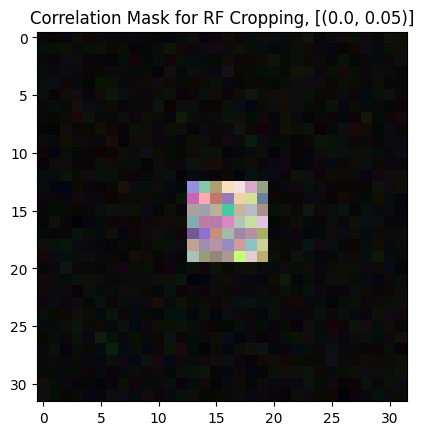

In [34]:
# Display the correlation mask
to_show = (correlation1[:, :, 12:] - correlation1[:, :, 12:].min()) / (correlation1[:, :, 12:].max() - correlation1[:, :, 12:].min())
plt.imshow(to_show)
plt.title(f'Correlation Mask for RF Cropping, [{np.round(float(correlation1[:, :, 12:].min()),2), np.round(float(correlation1[:, :, 12:].max()),2)}]')

In [35]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, _ = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

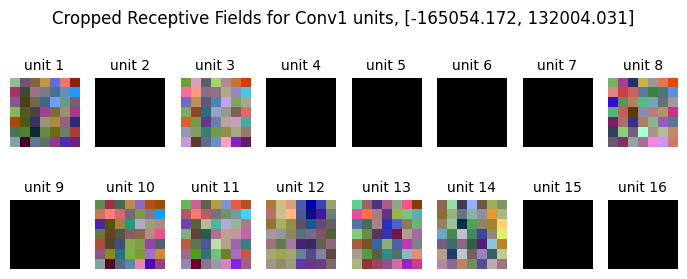

In [39]:
# Absolute = false - display cropped RFs
for i in range(rf_cropped1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields for Conv1 units, {[np.round(float(rf_cropped1.min()), 3), np.round(float(rf_cropped1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 5.5)
plt.show()

In [40]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 7, 7, 15])


Response-Weighted Covariance - Normal RWA

In [41]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [08:16<00:00, 1610.29it/s]


In [42]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov1: {cov1.shape}")

Shape of mu: torch.Size([16, 50000, 735])
Shape of cov1: torch.Size([16, 735, 735])


In [43]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

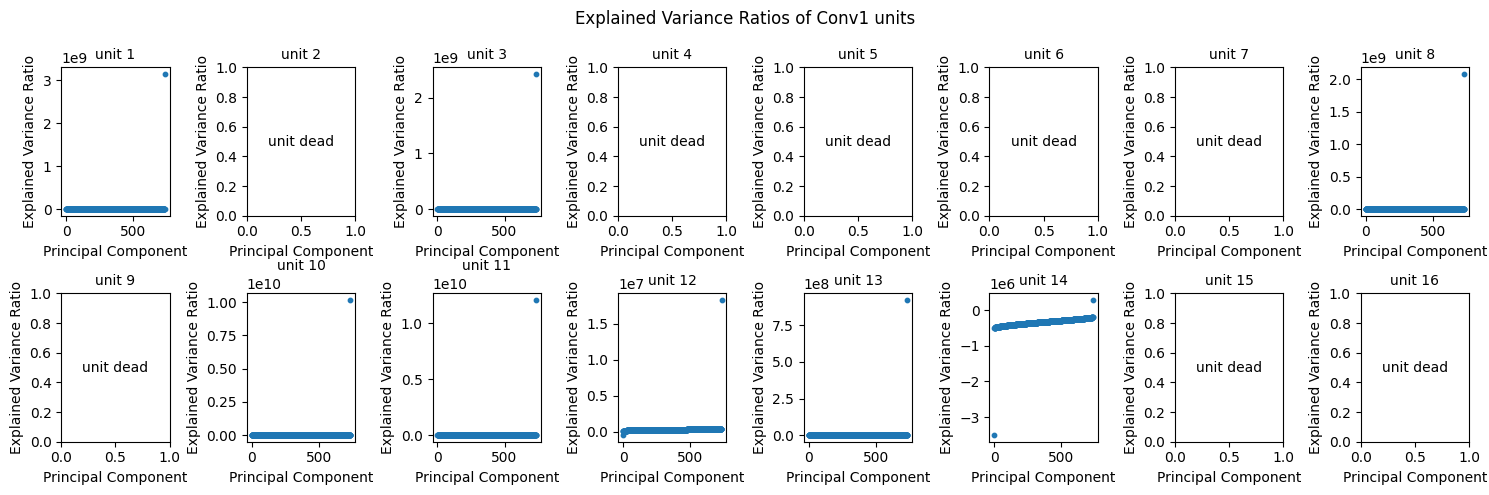

In [49]:
# visualise the eigenvalues
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        plt.scatter(range(len(eigenvalues1[i])), eigenvalues1[i], s=10)
    else:
        # show a text saying dead unit
        plt.text(0.5, 0.5, 'unit dead', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(15, 5)
plt.suptitle('Explained Variance Ratios of Conv1 units') 
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

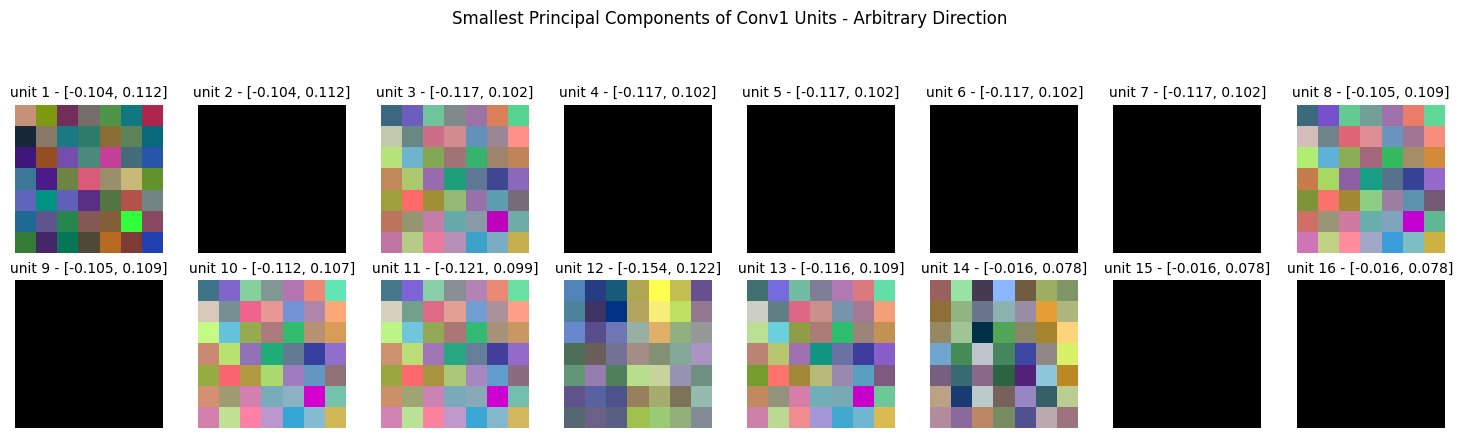

In [52]:
# Principal Components
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
        to_show = (x[:,:,12:] - x[:,:,12:].min()) / (x[:,:,12:].max() - x[:,:,12:].min())
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}', fontsize=10)
    plt.title(f'unit {str(i+1)} - {[np.round(float(x.min()),3), np.round(float(x.max()),3)]}', fontsize=10)

plt.suptitle(f'Smallest Principal Components of Conv1 Units - Arbitrary Direction') 
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

# Conv2 - Zero Mean [-127.5, 127.5]

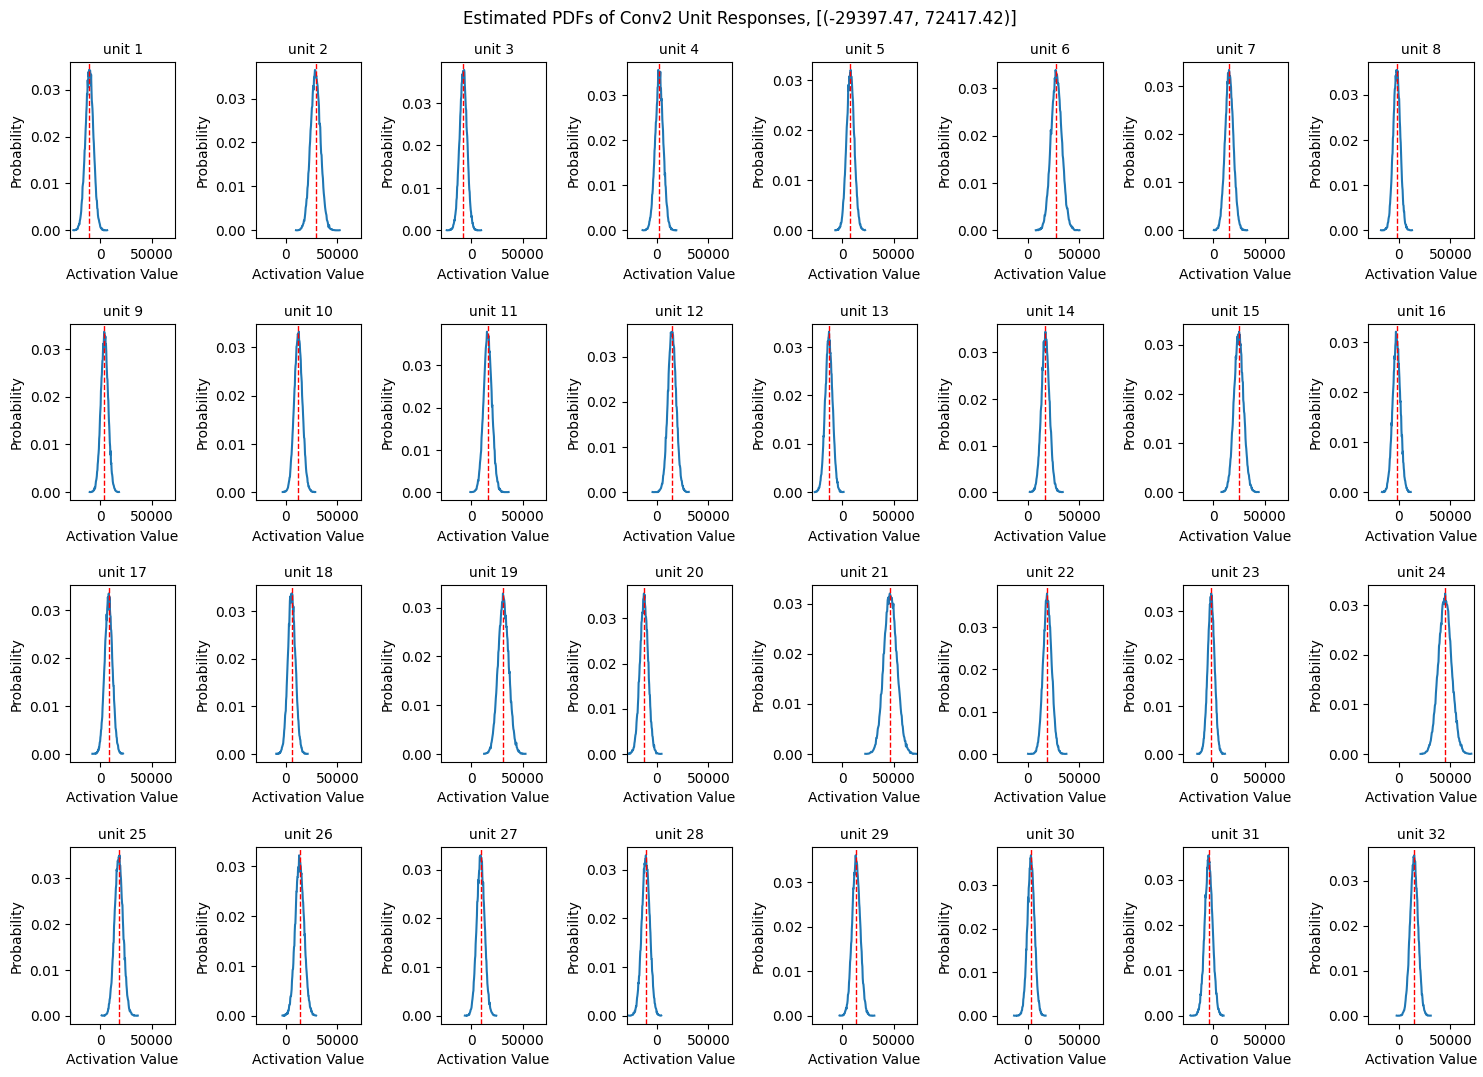

In [74]:
# PDFs of conv1 responses
# Gaussian because of CLT
for i in range(act_conv2.shape[0]):
    # plot initialisation
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    # plot the PDF of the activation values
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else: # display "unit dead"
        plt.text(0.5, 0.5, 'unit dead', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle(f'Estimated PDFs of Conv2 Unit Responses, [{np.round(float(act_conv2.min()),2), np.round(float(act_conv2.max()),2)}]')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 11)
plt.show()

In [75]:
# RWA - unbiased RF estimation, absolute false
rf2 = RWA(act_conv2, noise2, absolute=False)

100%|██████████| 1600000/1600000 [01:07<00:00, 23620.49it/s]


Shape of receptive field list: torch.Size([32, 32, 32, 15])


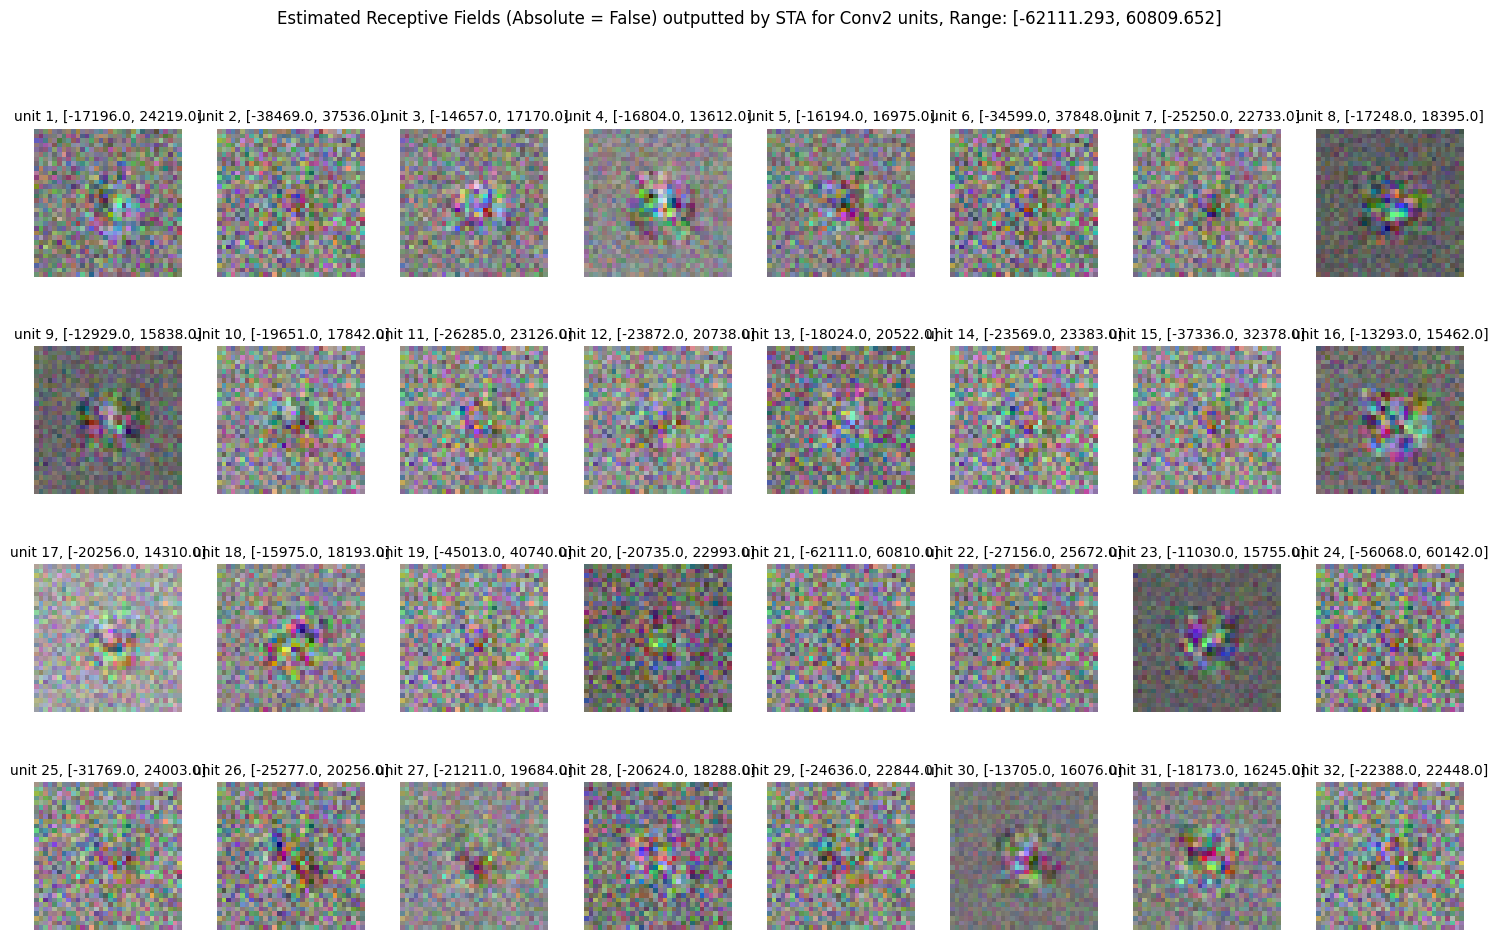

In [76]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], 3)))
    plt.title(f'unit {str(i+1)}, [{np.round(rf2[i].min())}, {np.round(rf2[i].max())}]', fontsize=10)
    
# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields (Absolute = False) outputted by STA for Conv2 units, Range: {[np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [77]:
# gets the correlation between the RF and the noise for each unit
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]): # loop through each channel
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

 62%|██████▏   | 20205/32768 [01:07<00:43, 290.56it/s]

In [ ]:
# Visualise the RWA output as image plots
for i in range(rf_corr2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], 3)))
    plt.title(f'unit {str(i+1)}', fontsize=10)

# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields outputted by Pearson Correlaiton for Conv2 units, {[np.round(float(rf_corr2.min()), 3), np.round(float(rf_corr2.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()